In [33]:
from env import ImgRouterEvalEnv
from lightning_lite.utilities.seed import seed_everything
from bandit_algo import BanditAlgorithm
from preference_estimator import (
    EmpiricalEstimator,
    NeuralEstimator,
    RecurrentNeuralEstimator,
    RecurrentNeuralEstimatorV0,
    DummyEstimator,
)
from exploration_strategy import (
    PerArmExploration,
    UniformEpsilonExploration,
    RandomRouting,
)
import numpy as np

import matplotlib.pyplot as plt
import torch
plt.style.use("fivethirtyeight")
import os
from copy import deepcopy
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"

import pandas as pd
from rich.console import Console
console = Console()

In [34]:
num_tasks = 3
num_cls = 10
reduce_fator = 2
# reduce_fator = 8
num_candidates = 256
# num_candidates = 512
num_slates = num_candidates // reduce_fator
use_img = True
# use_img = False

#max_steps = 200
max_steps = 200
num_seeds = 1

estimator_cfg = {
        "reset_period": 10,
    }


explore_cfg = {
    "epsilon": 2.0,
    "min_epsilon": 0.01,
    "decay_factor": 0.9,
    "exploit_factor": 4.0,
}

cfg = {
        "num_candidates": num_candidates,
        "max_steps": max_steps,
        "evaluate_strategy": "leave_one_out",
        # "evaluate_strategy": "each_one",
        # "evaluate_strategy": "uniform",
        "use_img": use_img,
    }

In [35]:
def main(algo, env):
    obs = env.reset()
    # print("initial obs:", obs)
    done = False
    step_rewards = []
    pred_losses = []
    model_perfs = [env.model.test_acc()]
    while not done:
        action = algo.predict(obs)
        next_obs, reward, done, info = env.step(action)
        algo.update_estimator(obs, action, info["rewards"])
        obs = next_obs
        step_rewards.append(reward)
        # pred_loss = (algo.estimator.Q - env.Q) ** 2
        # pred_losses.append(pred_loss)
        model_perfs.append(env.model.test_acc())

    print("current samples after training:")
    print(env.current_samples)
    # routed_data = env.current_samples - existing_samples
    # routed_data = env.current_samples
    # print("routed data:")
    # print(routed_data)
    print("reward:", np.mean(step_rewards))
    return step_rewards, model_perfs


In [36]:
def get_algos():
    algos = [(DummyEstimator, RandomRouting)]
    # estimators = [EmpiricalEstimator, 
    #                 NeuralEstimator,
    #                 RecurrentNeuralEstimatorV0,]
    # estimators = [  NeuralEstimator,
    #                 RecurrentNeuralEstimatorV0,]
    estimators = [EmpiricalEstimator,
                    NeuralEstimator,
                    RecurrentNeuralEstimatorV0,]
    algos += [
        (estimator,
        UniformEpsilonExploration) for estimator in estimators]
    
    
    return algos

In [37]:


torch.use_deterministic_algorithms(True)
estimator_step_rewards = {}
estimator_model_perfs = {}
estimator_routed_samples = {}
algos = get_algos()

for est_cls, explore_cls in algos:
    if use_img and est_cls == EmpiricalEstimator:
        continue
    step_rewards, model_perfs, routed_samples = [], [], []
    console.print(f"Estimator: {est_cls.__name__}", style="red")
    for seed in range(num_seeds):
        console.print(f"Seed: {seed}", style="blue")
        seed_everything(seed)
        env = ImgRouterEvalEnv(cfg)
        # skip EmpiricalEstimator
        algo = BanditAlgorithm(
            est_cls(num_tasks, num_cls, use_img=use_img, cfg=estimator_cfg),
            explore_cls(num_tasks, num_cls, num_slates, cfg=explore_cfg),
        )
        step_rewards_seed, model_perfs_seed = main(algo,env)
        routed_samples_seed = deepcopy(env.routed_samples_per_time)
        step_rewards.append(step_rewards_seed)
        model_perfs.append(model_perfs_seed)
        routed_samples.append(routed_samples_seed)
        print("\n\n")

    
    estimator_step_rewards[algo.estimator.__class__.__name__] = np.array(step_rewards)
    estimator_model_perfs[algo.estimator.__class__.__name__] = np.array(model_perfs)
    estimator_routed_samples[algo.estimator.__class__.__name__] = np.array(routed_samples)

Estimator: DummyEstimator

Seed: 0

Global seed set to 0


MNIST num parameters: 15298
routed_batch_z (tensor([0, 1, 2]), tensor([35, 38, 55]))
routed_batch_z (tensor([0, 1, 2]), tensor([39, 41, 48]))
routed_batch_z (tensor([0, 1, 2]), tensor([44, 41, 43]))
routed_batch_z (tensor([0, 1, 2]), tensor([40, 42, 46]))
routed_batch_z (tensor([0, 1, 2]), tensor([46, 45, 37]))
routed_batch_z (tensor([0, 1, 2]), tensor([45, 52, 31]))
routed_batch_z (tensor([0, 1, 2]), tensor([45, 42, 41]))
routed_batch_z (tensor([0, 1, 2]), tensor([43, 43, 42]))
routed_batch_z (tensor([0, 1, 2]), tensor([36, 49, 43]))
routed_batch_z (tensor([0, 1, 2]), tensor([36, 46, 46]))
routed_batch_z (tensor([0, 1, 2]), tensor([40, 48, 40]))
routed_batch_z (tensor([0, 1, 2]), tensor([41, 45, 42]))
routed_batch_z (tensor([0, 1, 2]), tensor([54, 36, 38]))
routed_batch_z (tensor([0, 1, 2]), tensor([48, 33, 47]))
routed_batch_z (tensor([0, 1, 2]), tensor([42, 41, 45]))
routed_batch_z (tensor([0, 1, 2]), tensor([42, 46, 40]))
routed_batch_z (tensor([0, 1, 2]), tensor([41, 39, 48]))
rou

Estimator: NeuralEstimator

Seed: 0

Global seed set to 0


Neural Estimator num params:  17605
epsilon 2.0, min_epislon 0.01, decay_factor 0.9, exploit_factor 4.0
MNIST num parameters: 15298
step 0 epsilon 2.0
routed_batch_z (tensor([0, 1, 2]), tensor([48, 45, 35]))
step 1 epsilon 1.8
routed_batch_z (tensor([0, 1, 2]), tensor([40, 54, 34]))
step 2 epsilon 1.62
routed_batch_z (tensor([0, 1, 2]), tensor([50, 42, 36]))
step 3 epsilon 1.4580000000000002
routed_batch_z (tensor([0, 1, 2]), tensor([43, 40, 45]))
step 4 epsilon 1.3122000000000003
routed_batch_z (tensor([0, 1, 2]), tensor([46, 45, 37]))
step 5 epsilon 1.1809800000000004
routed_batch_z (tensor([0, 1, 2]), tensor([31, 46, 51]))
step 6 epsilon 1.0628820000000003
routed_batch_z (tensor([0, 1, 2]), tensor([38, 41, 49]))
step 7 epsilon 0.9565938000000003
routed_batch_z (tensor([0, 1, 2]), tensor([35, 47, 46]))
step 8 epsilon 0.8609344200000003
routed_batch_z (tensor([0, 1, 2]), tensor([40, 47, 41]))
step 9 epsilon 0.7748409780000003
routed_batch_z (tensor([0, 1, 2]), tensor([55, 36, 37]))
st

Estimator: RecurrentNeuralEstimatorV0

Seed: 0

Global seed set to 0


Recurrent Estimator (one-feed) Num params 72037
epsilon 2.0, min_epislon 0.01, decay_factor 0.9, exploit_factor 4.0
MNIST num parameters: 15298
step 0 epsilon 2.0
routed_batch_z (tensor([0, 1, 2]), tensor([45, 44, 39]))


>> RESET

step 1 epsilon 1.8
routed_batch_z (tensor([0, 1, 2]), tensor([46, 37, 45]))
step 2 epsilon 1.62
routed_batch_z (tensor([0, 1, 2]), tensor([47, 37, 44]))
step 3 epsilon 1.4580000000000002
routed_batch_z (tensor([0, 1, 2]), tensor([50, 41, 37]))
step 4 epsilon 1.3122000000000003
routed_batch_z (tensor([0, 1, 2]), tensor([41, 48, 39]))
step 5 epsilon 1.1809800000000004
routed_batch_z (tensor([0, 1, 2]), tensor([42, 44, 42]))
step 6 epsilon 1.0628820000000003
routed_batch_z (tensor([0, 1, 2]), tensor([50, 38, 40]))
step 7 epsilon 0.9565938000000003
routed_batch_z (tensor([0, 1, 2]), tensor([51, 43, 34]))
step 8 epsilon 0.8609344200000003
routed_batch_z (tensor([0, 1, 2]), tensor([45, 48, 35]))
step 9 epsilon 0.7748409780000003
routed_batch_z (tensor([0, 1, 2]), tensor([56, 39, 33]))
step 10 epsilon 0.6973568802000003
routed_batch_z (tensor([0, 1, 2]), tensor([39, 42, 47]))


>> RESET

step 11 epsilon 0.6276211921800003
routed_batch_z (tensor([0, 1, 2]), tensor([59, 35, 34]))
step 12 epsilon 0.5648590729620003
routed_batch_z (tensor([0, 1, 2]), tensor([57, 44, 27]))
step 13 epsilon 0.5083731656658003
routed_batch_z (tensor([0, 1, 2]), tensor([50, 34, 44]))
step 14 epsilon 0.45753584909922024
routed_batch_z (tensor([0, 1, 2]), tensor([61, 30, 37]))
step 15 epsilon 0.4117822641892982
routed_batch_z (tensor([0, 1, 2]), tensor([62, 33, 33]))
step 16 epsilon 0.3706040377703684
routed_batch_z (tensor([0, 1, 2]), tensor([72, 35, 21]))
step 17 epsilon 0.33354363399333153
routed_batch_z (tensor([0, 1, 2]), tensor([77, 21, 30]))
step 18 epsilon 0.3001892705939984
routed_batch_z (tensor([0, 1, 2]), tensor([59, 34, 35]))
step 19 epsilon 0.27017034353459857
routed_batch_z (tensor([0, 1, 2]), tensor([69, 34, 25]))
step 20 epsilon 0.24315330918113873
routed_batch_z (tensor([0, 1, 2]), tensor([73, 31, 24]))


>> RESET

step 21 epsilon 0.21883797826302487
routed_batch_z (tensor([0, 1, 2]), tensor([75, 30, 23]))
step 22 epsilon 0.1969541804367224
routed_batch_z (tensor([0, 1, 2]), tensor([71, 32, 25]))
step 23 epsilon 0.17725876239305016
routed_batch_z (tensor([0, 1, 2]), tensor([82, 24, 22]))
step 24 epsilon 0.15953288615374514
routed_batch_z (tensor([0, 1, 2]), tensor([85, 15, 28]))
step 25 epsilon 0.14357959753837063
routed_batch_z (tensor([0, 1, 2]), tensor([85, 19, 24]))
step 26 epsilon 0.12922163778453358
routed_batch_z (tensor([0, 1, 2]), tensor([89, 17, 22]))
step 27 epsilon 0.11629947400608022
routed_batch_z (tensor([0, 1, 2]), tensor([92, 21, 15]))
step 28 epsilon 0.1046695266054722
routed_batch_z (tensor([0, 1, 2]), tensor([81, 26, 21]))
step 29 epsilon 0.09420257394492498
routed_batch_z (tensor([0, 1, 2]), tensor([76, 22, 30]))
step 30 epsilon 0.08478231655043249
routed_batch_z (tensor([0, 1, 2]), tensor([81, 27, 20]))


>> RESET

step 31 epsilon 0.07630408489538924
routed_batch_z (tensor([0, 1, 2]), tensor([94, 18, 16]))
step 32 epsilon 0.06867367640585031
routed_batch_z (tensor([0, 1, 2]), tensor([77, 22, 29]))
step 33 epsilon 0.061806308765265286
routed_batch_z (tensor([0, 1, 2]), tensor([82, 22, 24]))
step 34 epsilon 0.05562567788873876
routed_batch_z (tensor([0, 1, 2]), tensor([95, 18, 15]))
step 35 epsilon 0.05006311009986489
routed_batch_z (tensor([0, 1, 2]), tensor([77, 28, 23]))
step 36 epsilon 0.0450567990898784
routed_batch_z (tensor([0, 1, 2]), tensor([75, 22, 31]))
step 37 epsilon 0.040551119180890556
routed_batch_z (tensor([0, 1, 2]), tensor([81, 23, 24]))
step 38 epsilon 0.0364960072628015
routed_batch_z (tensor([0, 1, 2]), tensor([84, 26, 18]))
step 39 epsilon 0.03284640653652135
routed_batch_z (tensor([0, 1, 2]), tensor([95, 17, 16]))
step 40 epsilon 0.029561765882869215
routed_batch_z (tensor([0, 1, 2]), tensor([94, 17, 17]))


>> RESET

step 41 epsilon 0.026605589294582295
routed_batch_z (tensor([0, 1, 2]), tensor([79, 18, 31]))
step 42 epsilon 0.023945030365124065
routed_batch_z (tensor([0, 1, 2]), tensor([80, 27, 21]))
step 43 epsilon 0.02155052732861166
routed_batch_z (tensor([0, 1, 2]), tensor([85, 20, 23]))
step 44 epsilon 0.019395474595750493
routed_batch_z (tensor([0, 1, 2]), tensor([80, 28, 20]))
step 45 epsilon 0.017455927136175445
routed_batch_z (tensor([0, 1, 2]), tensor([93, 14, 21]))
sending all non-zero weights

step 46 epsilon 0.0157103344225579
routed_batch_z (tensor([0, 2]), tensor([65,  7]))
sending all non-zero weights

step 47 epsilon 0.01413930098030211
routed_batch_z (tensor([0, 2]), tensor([56,  3]))
sending all non-zero weights

step 48 epsilon 0.0127253708822719
routed_batch_z (tensor([0]), tensor([52]))
sending all non-zero weights

step 49 epsilon 0.01145283379404471
routed_batch_z (tensor([0, 1, 2]), tensor([63,  1,  1]))
sending all non-zero weights

step 50 epsilon 0.01030755041464024
rou

>> RESET

sending all non-zero weights

step 51 epsilon 0.01
routed_batch_z (tensor([0]), tensor([64]))
sending all non-zero weights

step 52 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([83,  4,  8]))
sending all non-zero weights

step 53 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([87,  5,  9]))
sending all non-zero weights

step 54 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([72,  7, 11]))
step 55 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84, 23, 21]))
step 56 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84, 19, 25]))
step 57 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([90, 10, 28]))
step 58 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([82, 16, 30]))
step 59 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([78, 21, 29]))
step 60 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([77, 17, 34]))


>> RESET

step 61 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([87, 17, 24]))
step 62 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([89, 23, 16]))
step 63 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([88, 11, 29]))
step 64 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([79, 18, 31]))
step 65 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([85, 15, 28]))
step 66 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84, 19, 25]))
step 67 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([83, 15, 30]))
step 68 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([71, 20, 37]))
step 69 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([87,  9, 32]))
step 70 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([83, 13, 32]))


>> RESET

step 71 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([83, 12, 33]))
step 72 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([83, 18, 27]))
step 73 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([81, 17, 30]))
step 74 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([89, 14, 25]))
step 75 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([95,  8, 25]))
step 76 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([81, 18, 29]))
step 77 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([80, 15, 33]))
step 78 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([73, 25, 30]))
step 79 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([81, 21, 26]))
step 80 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([86, 15, 27]))


>> RESET

step 81 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84, 15, 29]))
step 82 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([87, 12, 29]))
step 83 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([74, 21, 33]))
step 84 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([90, 13, 25]))
step 85 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([90, 12, 26]))
sending all non-zero weights

step 86 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([78, 14, 29]))
step 87 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84, 21, 23]))
sending all non-zero weights

step 88 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([87, 16, 20]))
step 89 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([98, 10, 20]))
step 90 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([82, 11, 35]))


>> RESET

sending all non-zero weights

step 91 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([81,  8, 25]))
sending all non-zero weights

step 92 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([79,  2, 23]))
sending all non-zero weights

step 93 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([92,  1, 18]))
sending all non-zero weights

step 94 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([75,  9]))
sending all non-zero weights

step 95 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([90,  5, 11]))
sending all non-zero weights

step 96 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([89,  1, 12]))
sending all non-zero weights

step 97 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84,  1, 24]))
sending all non-zero weights

step 98 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([81,  3]))
sending all non-zero weights

step 99 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([73,  5]))
sending all non-zero weights

step 100 epsilon 0.

>> RESET

sending all non-zero weights

step 101 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([82,  2]))
sending all non-zero weights

step 102 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([77,  1]))
sending all non-zero weights

step 103 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([86,  3,  9]))
sending all non-zero weights

step 104 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([85,  9]))
sending all non-zero weights

step 105 epsilon 0.01
routed_batch_z (tensor([0]), tensor([79]))
sending all non-zero weights

step 106 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([75,  2]))
sending all non-zero weights

step 107 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([82,  1]))
sending all non-zero weights

step 108 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([68,  3]))
sending all non-zero weights

step 109 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([70,  1,  4]))
sending all non-zero weights

step 110 epsilon 0.01
routed_batch_z (tensor(

>> RESET

sending all non-zero weights

step 111 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([81,  6]))
sending all non-zero weights

step 112 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([76, 11]))
sending all non-zero weights

step 113 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([79,  4]))
sending all non-zero weights

step 114 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([84,  8]))
sending all non-zero weights

step 115 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([73,  1, 14]))
sending all non-zero weights

step 116 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([89,  3]))
sending all non-zero weights

step 117 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([79,  3, 13]))
sending all non-zero weights

step 118 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([69, 10]))
sending all non-zero weights

step 119 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([86,  3, 12]))
sending all non-zero weights

step 120 epsilon 0.01
routed_ba

>> RESET

sending all non-zero weights

step 121 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([76, 10, 24]))
sending all non-zero weights

step 122 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([83,  9, 13]))
sending all non-zero weights

step 123 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([79,  8, 34]))
step 124 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([102,   4,  22]))
sending all non-zero weights

step 125 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([92,  9, 15]))
step 126 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([105,   7,  16]))
step 127 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([88, 11, 29]))
step 128 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([90,  7, 31]))
step 129 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([107,   6,  15]))
step 130 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([103,  12,  13]))


>> RESET

step 131 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([92, 13, 23]))
step 132 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([90, 16, 22]))
step 133 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([94, 13, 21]))
step 134 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([86, 13, 29]))
step 135 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([73, 22, 33]))
step 136 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([83, 16, 29]))
step 137 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([78, 22, 28]))
step 138 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([87, 15, 26]))
step 139 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([93, 11, 24]))
step 140 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([95, 12, 21]))


>> RESET

step 141 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84, 10, 34]))
step 142 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([70, 24, 34]))
step 143 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84,  8, 36]))
step 144 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([74, 19, 35]))
step 145 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([91, 10, 27]))
step 146 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([83, 16, 29]))
step 147 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([80, 18, 30]))
step 148 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84, 12, 32]))
step 149 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([97,  5, 26]))
step 150 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([89, 13, 26]))


>> RESET

step 151 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84, 12, 32]))
step 152 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([94,  6, 28]))
step 153 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([80, 15, 33]))
step 154 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([81, 19, 28]))
step 155 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([87,  8, 33]))
step 156 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([70, 18, 40]))
step 157 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([94,  7, 27]))
step 158 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([86, 12, 30]))
step 159 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([76, 15, 37]))
step 160 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([98,  4, 26]))


>> RESET

step 161 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([73, 17, 38]))
step 162 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([87,  6, 35]))
step 163 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([81,  7, 40]))
step 164 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([86,  7, 35]))
step 165 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([88,  9, 31]))
step 166 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([86, 14, 28]))
step 167 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([91, 12, 25]))
step 168 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([81, 16, 31]))
step 169 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([64, 29, 35]))
step 170 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([86,  8, 34]))


>> RESET

step 171 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([76, 19, 33]))
step 172 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([90,  7, 31]))
step 173 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([90, 10, 28]))
step 174 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([81, 13, 34]))
step 175 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([83, 13, 32]))
step 176 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([85, 13, 30]))
step 177 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([89, 13, 26]))
step 178 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([82, 12, 34]))
step 179 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84, 15, 29]))
step 180 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([85,  9, 34]))


>> RESET

step 181 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([87,  8, 33]))
step 182 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84, 15, 29]))
step 183 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([91, 11, 26]))
step 184 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([88, 13, 27]))
step 185 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([85, 21, 22]))
step 186 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([72, 24, 32]))
step 187 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([86, 17, 25]))
step 188 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([96,  9, 23]))
step 189 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([79, 15, 34]))
step 190 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([80, 10, 38]))


>> RESET

step 191 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([88, 13, 27]))
step 192 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([104,   9,  15]))
step 193 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([89,  9, 30]))
step 194 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([78, 21, 29]))
step 195 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84, 12, 32]))
step 196 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([86, 19, 23]))
step 197 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([77, 20, 31]))
step 198 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([88, 16, 24]))
step 199 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([96,  8, 24]))
current samples after training:
[[1576. 1780. 1602. 1641. 1578. 1446. 1591. 1638. 1595. 1627.]
 [ 136.  541.   84.  375.  147.  553.  132.  357.  202.  445.]
 [ 247.  736.  703.  221.  530.  201. 1016.  547.  323.  349.]]
reward: 0.964997116485224





[8501. 8466. 8633.]
[15702.  5004.  4894.]
[15460.  4646.  5494.]
[15679.  4295.  5626.]


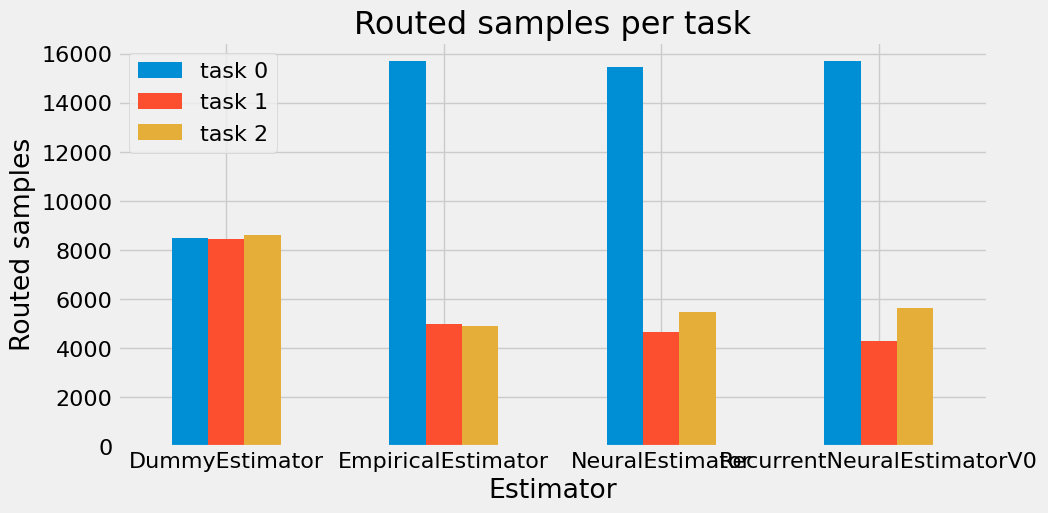

In [15]:
df = pd.DataFrame(columns=["estimator", "task 0", "task 1", "task 2"])
for i, (est_cls, routed_samples) in enumerate(estimator_routed_samples.items()):
    task_routed_samples = routed_samples.sum(axis=(1, 3)).mean(axis=0)
    print(task_routed_samples)
    df.loc[i] = [est_cls] + list(task_routed_samples)

# df plot where task 0, 1, 2 are the columns
df.plot.bar(x="estimator", rot=0, figsize=(10, 5))
plt.title("Routed samples per task")
plt.ylabel("Routed samples")
plt.xlabel("Estimator");


DummyEstimator task: 0 routed_samples: 42.505
EmpiricalEstimator task: 0 routed_samples: 78.51
NeuralEstimator task: 0 routed_samples: 77.3
RecurrentNeuralEstimatorV0 task: 0 routed_samples: 78.395
DummyEstimator task: 1 routed_samples: 42.33
EmpiricalEstimator task: 1 routed_samples: 25.02
NeuralEstimator task: 1 routed_samples: 23.23
RecurrentNeuralEstimatorV0 task: 1 routed_samples: 21.475
DummyEstimator task: 2 routed_samples: 43.165
EmpiricalEstimator task: 2 routed_samples: 24.47
NeuralEstimator task: 2 routed_samples: 27.47
RecurrentNeuralEstimatorV0 task: 2 routed_samples: 28.13


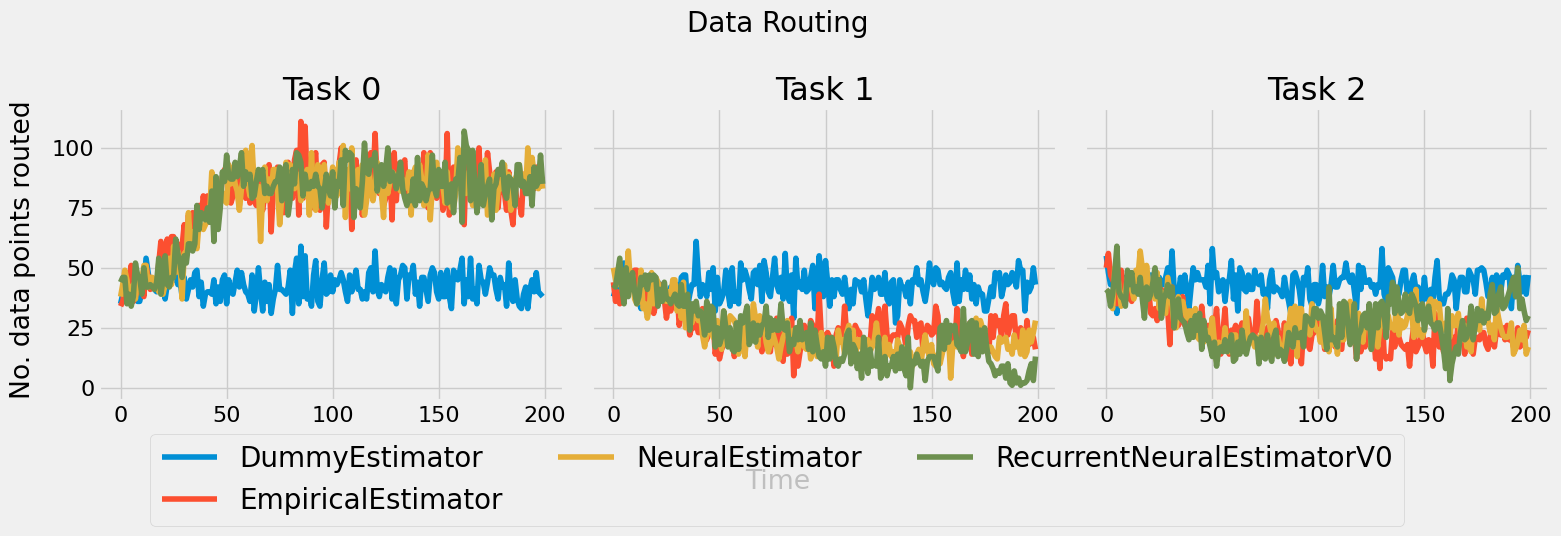

In [16]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(16, 5))

for task in range(3):
    for estimator_name, routed_samples in estimator_routed_samples.items():
        routed_samples_task = routed_samples.sum(axis=-1)[:, :, task]  # sum over classes
        ax[task].plot(routed_samples_task.mean(axis=0), label=estimator_name)
        std = routed_samples_task.std(axis=0)
        ax[task].fill_between(
            np.arange(len(std)),
            routed_samples_task.mean(axis=0) - std,
            routed_samples_task.mean(axis=0) + std,
            alpha=0.2,
        )
        ax[task].set_title(f"Task {task}")
        print(estimator_name, "task:", task, "routed_samples:", np.mean(routed_samples_task))

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', ncol=3, fontsize=20, bbox_to_anchor=(0.9, -0.08));
fig.suptitle("Data Routing", fontsize=20)
plt.rcParams.update({'font.size': 16})
fig.supxlabel("Time")
fig.supylabel("No. data points routed")
plt.tight_layout();

DummyEstimator 0.4124806725978851
EmpiricalEstimator 0.9261571273207665
NeuralEstimator 1.215169062614441
RecurrentNeuralEstimatorV0 0.8368818444013596


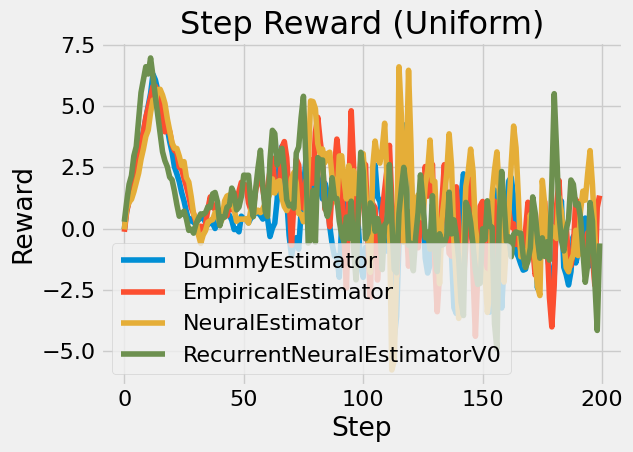

In [17]:
plt.title("Step Reward (Uniform)")
plt.ylabel("Reward")
plt.xlabel("Step")
for estimator_name, step_rewards in estimator_step_rewards.items():
    plt.plot(step_rewards.mean(axis=0), label=estimator_name)
    std = step_rewards.std(axis=0)
    plt.fill_between(
        np.arange(len(std)),
        step_rewards.mean(axis=0) - std,
        step_rewards.mean(axis=0) + std,
        alpha=0.2,
    )
    print(estimator_name, np.mean(step_rewards))
plt.legend(loc="best");
plt.tight_layout()

DummyEstimator 0.4143333231372323 0.6301999688148499
EmpiricalEstimator 0.533621380077814 0.7983999848365784
NeuralEstimator 0.4717611821931735 0.7651000022888184
RecurrentNeuralEstimatorV0 0.5452935197089442 0.7346000075340271


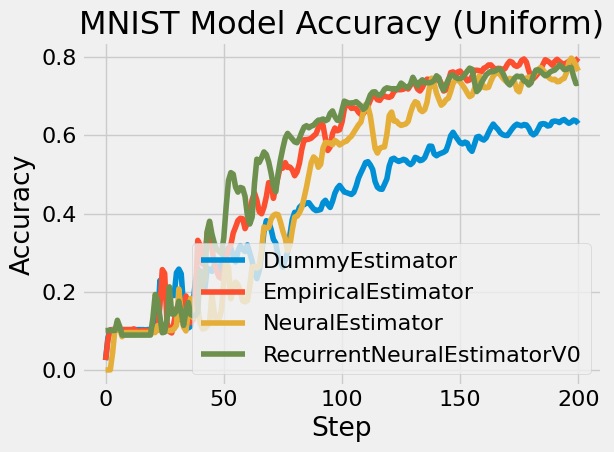

In [18]:
plt.title("MNIST Model Accuracy (Uniform)")
plt.ylabel("Accuracy")
plt.xlabel("Step")
for estimator_name, model_perfs in estimator_model_perfs.items():
    plt.plot(model_perfs.mean(axis=0), label=estimator_name)
    std = model_perfs.std(axis=0)
    plt.fill_between(
        np.arange(len(std)),
        model_perfs.mean(axis=0) - std,
        model_perfs.mean(axis=0) + std,
        alpha=0.2,
    )
    print(estimator_name, np.mean(model_perfs), model_perfs.mean(axis=0)[-1])
plt.legend(loc="best");
plt.tight_layout()

In [19]:
estimator_model_perfs_reduce2_no_image = estimator_model_perfs

In [10]:
estimator_model_perfs_reduce2_image = estimator_model_perfs

In [ ]:
# estimator_model_perfs_reduce2 = estimator_model_perfs

In [ ]:
# estimator_model_perfs_reduce8 = estimator_model_perfs

DummyEstimator 0.4143333231372323 0.6301999688148499
EmpiricalEstimator 0.533621380077814 0.7983999848365784
NeuralEstimator 0.4717611821931735 0.7651000022888184
RecurrentNeuralEstimatorV0 0.5452935197089442 0.7346000075340271
NeuralEstimator 0.4911795906816373 0.7696999907493591
RecurrentNeuralEstimatorV0 0.508424862385241 0.7946999669075012


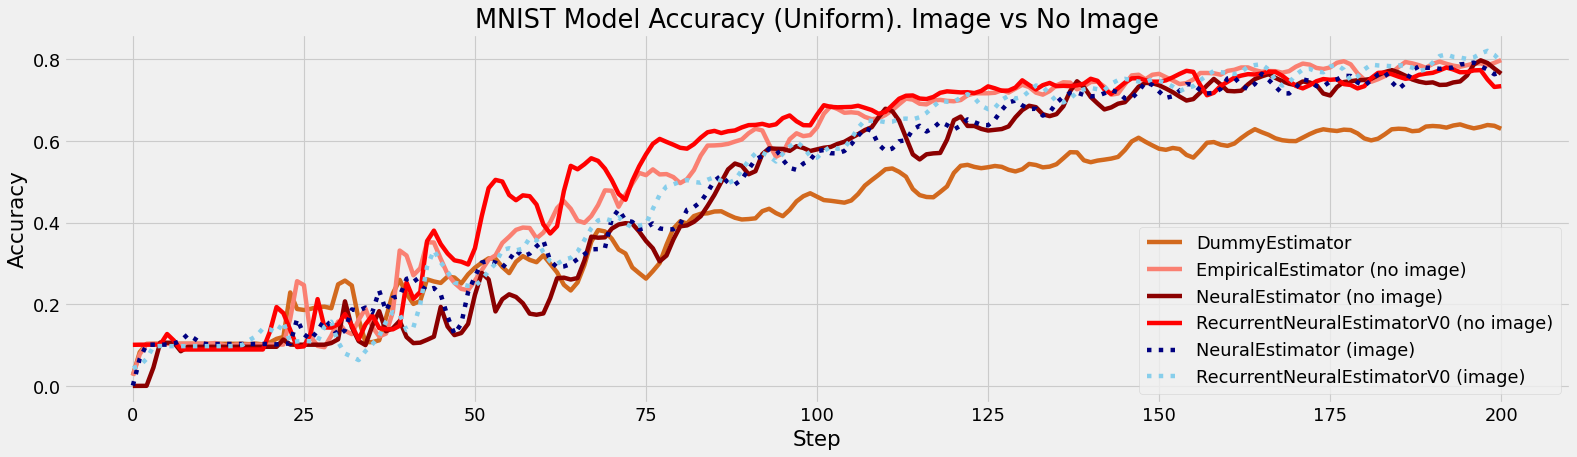

In [32]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.title("MNIST Model Accuracy (Uniform). Image vs No Image")
plt.ylabel("Accuracy")
plt.xlabel("Step")

reduce_2_colors = ["red", "darkred", "salmon", "chocolate"]
reduce_8_colors = ["blue", "skyblue", "navy"]

for estimator_name, model_perfs in estimator_model_perfs_reduce2_no_image.items():
    if estimator_name == "DummyEstimator":
        label = estimator_name
    else:
        label = estimator_name + " (no image)"
    plt.plot(model_perfs.mean(axis=0), label= label, color=reduce_2_colors.pop())
    std = model_perfs.std(axis=0)
    plt.fill_between(
        np.arange(len(std)),
        model_perfs.mean(axis=0) - std,
        model_perfs.mean(axis=0) + std,
        alpha=0.2,
    )
    print(estimator_name, np.mean(model_perfs), model_perfs.mean(axis=0)[-1])

for estimator_name, model_perfs in estimator_model_perfs_reduce2_image.items():
    if estimator_name == "DummyEstimator":
        continue
    label = estimator_name + " (image)"
    plt.plot(model_perfs.mean(axis=0), label=label, linestyle='dotted', color=reduce_8_colors.pop())
    std = model_perfs.std(axis=0)
    plt.fill_between(
        np.arange(len(std)),
        model_perfs.mean(axis=0) - std,
        model_perfs.mean(axis=0) + std,
        alpha=0.2,
    )
    print(estimator_name, np.mean(model_perfs), model_perfs.mean(axis=0)[-1])
plt.legend(loc="lower right");
plt.tight_layout()

